# Asteroseismology Variable Star with lightkurve

Notebook ini membantu kita mengenal lebih jauh tentang asteroseismologi pada bintang variabel, kita akan menurunkan parameter fisis dari bintang dan membandingkannya dengan literatur atau penelitian sebelumnya

Tutorial lightkurve tersedia pada https://docs.lightkurve.org/ !

In [ ]:
!pip install lightkurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 30.1 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11374 sha256=b247c40a06db3433ee31009639a237fbdd2fce457aa614fd95fc599d9cc46cca
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50451 sha256=c39030c8a7af455363e1201d0cbedd1320af4bcb7c549976b498b8d54c471735
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b553d5e

In [ ]:
import matplotlib
%matplotlib inline
import warnings
import lightkurve as lk
warnings.filterwarnings('ignore')
matplotlib.style.use('seaborn-white')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Kita akan coba untuk mencari timeseries dari bintang EH Librae

In [ ]:
datalist = lk.search_lightcurve('EH Lib', exptime=120)
datalist

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,120,157861023,0.0


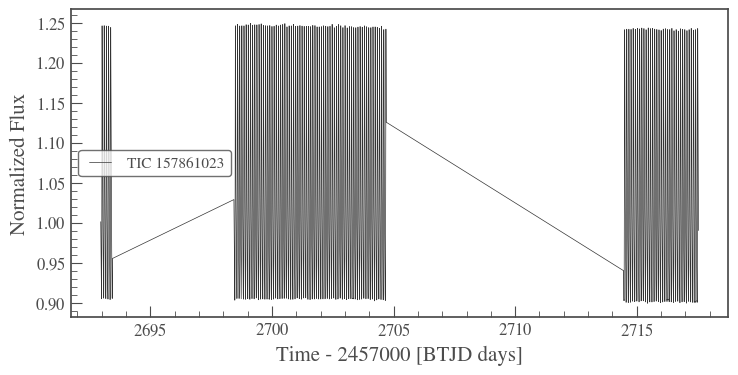

In [ ]:
lc = datalist.download().normalize().remove_outliers().remove_nans()
lc.plot()
matplotlib.pyplot.savefig('timeseries data.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Kita sudah mendapat data, dan akan melakukan asteroseismologi dengan data ini!

kita akan membuat periodogram lomb-scargle

<Quantity 0.08841902 d>

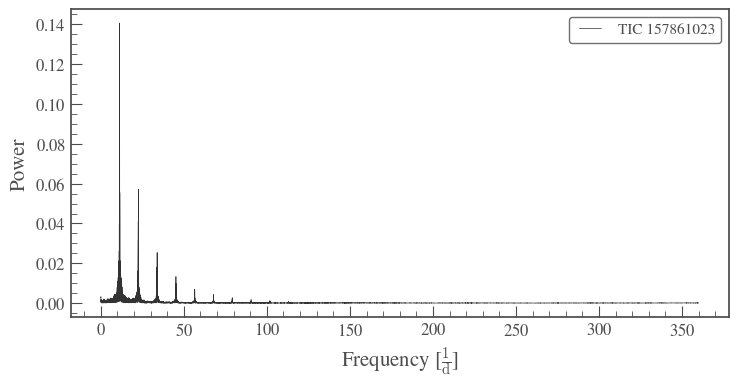

In [ ]:
pg = lc.to_periodogram(nterms=3)
pg.plot();
period = pg.period_at_max_power
period

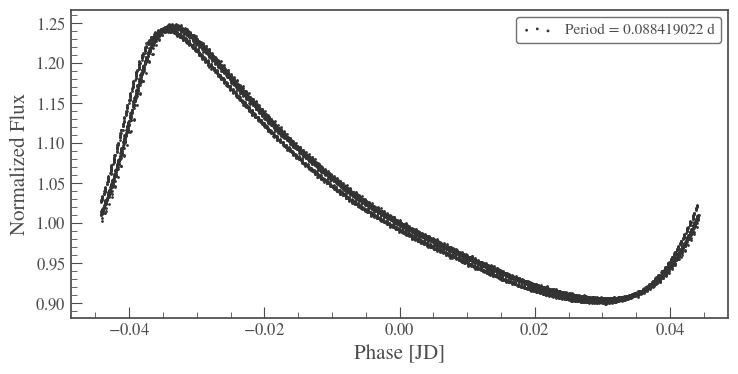

In [ ]:
lc.fold(period).scatter(label=f'Period = {period.value:.9f} d')
matplotlib.pyplot.savefig('test.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

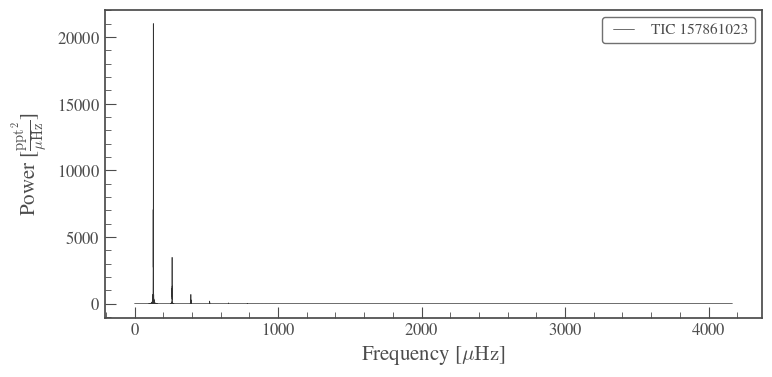

In [ ]:
pg = lc.normalize(unit='ppt').to_periodogram(normalization='psd')
pg.plot();

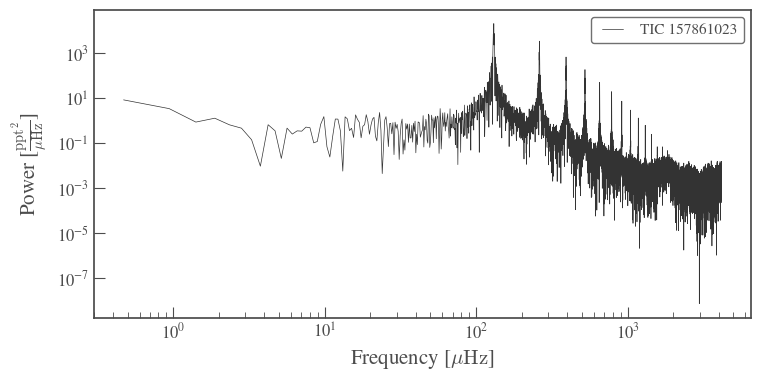

In [ ]:
pg.plot(scale='log')
matplotlib.pyplot.savefig('periodogram.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)

(0.2, 3000)

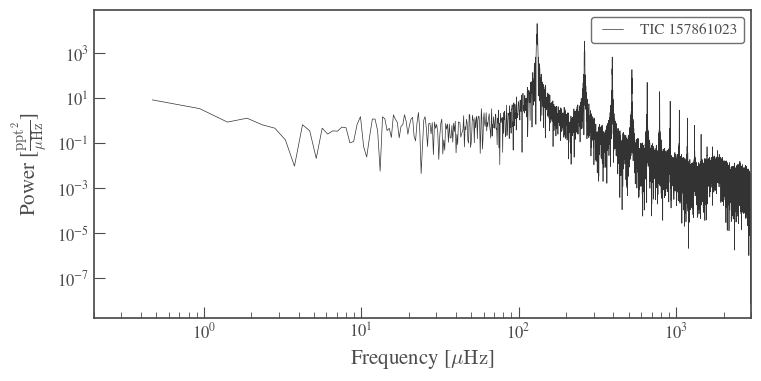

In [ ]:
ax = pg.plot(scale='log')
ax.set_xlim(0.2,3000)

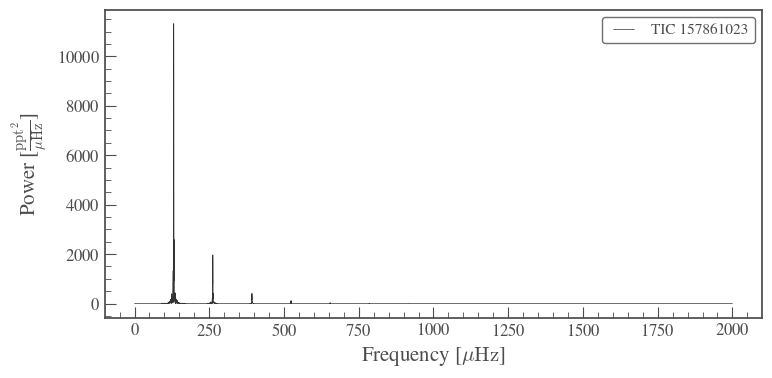

In [ ]:
pg = lc.normalize(unit='ppt').to_periodogram(normalization='psd', minimum_frequency=0.2, maximum_frequency=2000)
pg.plot()
matplotlib.pyplot.savefig('periodogram.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# Perform bootstrap to estimate uncertainties
n_boots = 100  # Number of bootstraps, you can adjust this as needed
bootstrap_power_spectra = pg.bootstrap(n_boots)
frequencies = bootstrap_power_spectra.frequency.value
power = bootstrap_power_spectra.power.value

# Find the mean and standard deviation of the power spectrum at each frequency bin
mean_power = power.mean(axis=0)
std_power = power.std(axis=0)

# Plot the mean power spectrum with uncertainties
plt.errorbar(frequencies, mean_power, yerr=std_power, fmt='o')


AttributeError: ignored

kita juga plotting untuk smoothed periodogramnya

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power [$\\mathrm{\\frac{ppt^{2}}{\\mu Hz}}$]'>

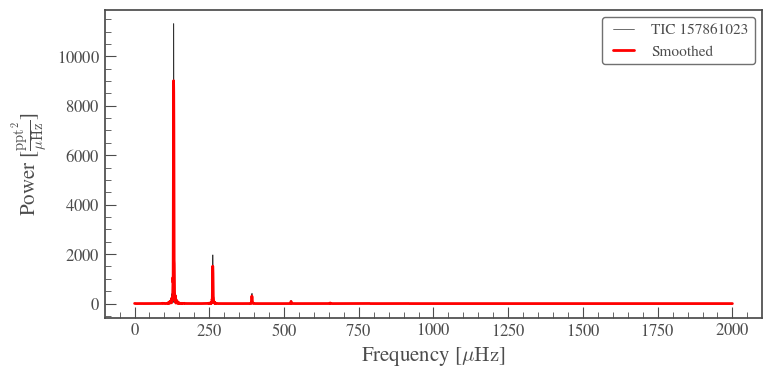

In [ ]:
ax = pg.plot()
pg.smooth(method='boxkernel', filter_width=1.).plot(ax=ax, label='Smoothed', c='red', lw=2)

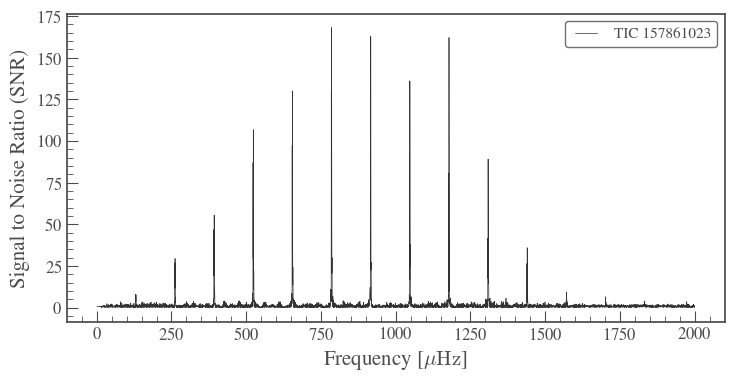

In [ ]:
snr = pg.flatten()
snr.plot()
matplotlib.pyplot.savefig('snr seis.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
seis = snr.to_seismology()
seis

Seismology(ID: TIC 157861023) - no values have been computed so far.

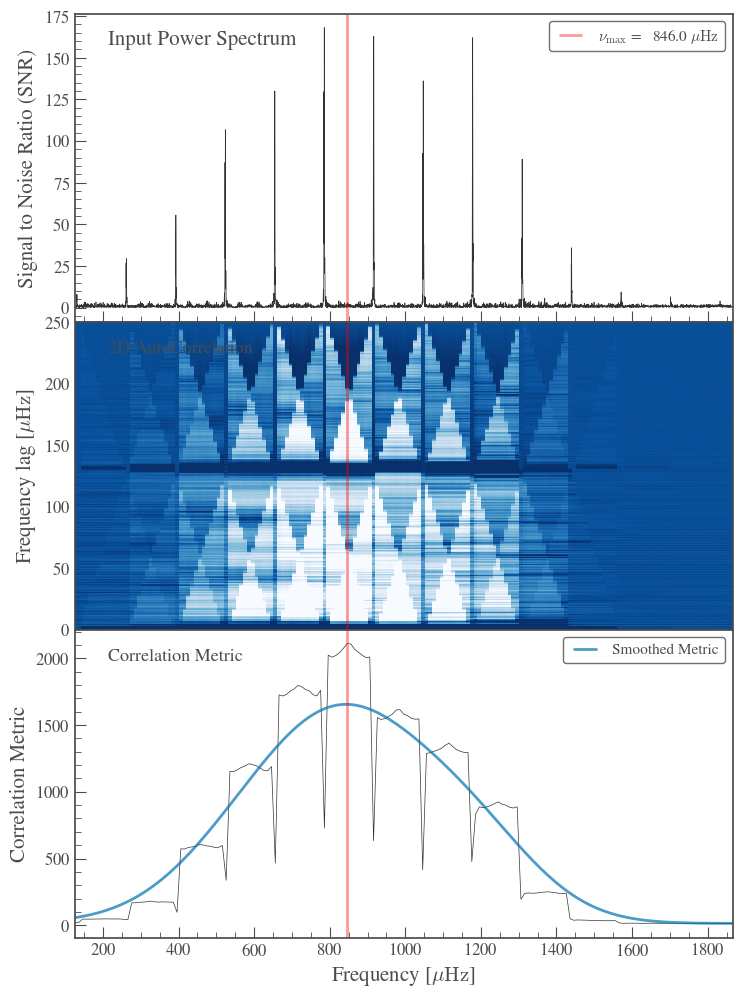

In [ ]:
seis.estimate_numax()
seis.diagnose_numax()
matplotlib.pyplot.savefig('numax.png', dpi=600, bbox_inches='tight', pad_inches=0.1)

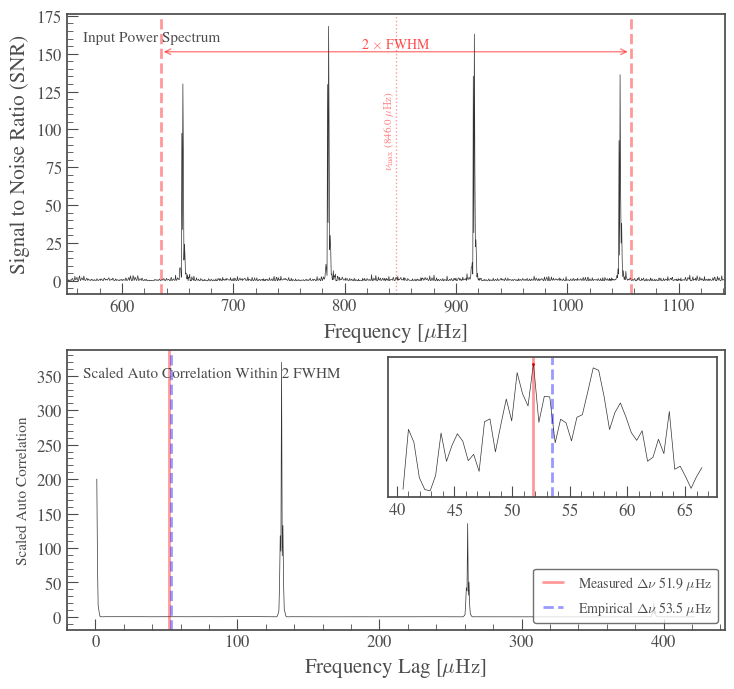

In [ ]:
seis.estimate_deltanu()
seis.diagnose_deltanu()
matplotlib.pyplot.savefig('deltanu.png', dpi=600, bbox_inches='tight', pad_inches=0.1)

data taken from any literature, teff diambil dari hasil penelitian TA Sulthan

In [ ]:
Teff = 7549
trueradius = 2.4
truemass = 1.53
truelogg = 4.04
mass = seis.estimate_mass(Teff)
radius = seis.estimate_radius(Teff)
logg = seis.estimate_logg(Teff)
print('Radius : {} vs {:.2f} Rsol'.format(trueradius, radius.value))
print('Mass : {} vs {:.2f} Msol'.format(truemass, mass.value))
print('logg : {} vs {:.2f} dex'.format(truelogg, logg.value))

Radius : 2.4 vs 2.13 Rsol
Mass : 1.53 vs 1.41 Msol
logg : 4.04 vs 3.93 dex


In [ ]:
print(seis)

Seismology(ID: TIC 157861023) - computed values:
 * numax: 846.00 uHz (method: ACF2D)
 * deltanu: 51.85 uHz (method: ACF2D)
 * mass: 1.41 solMass (method: Uncorrected Scaling Relations)
 * radius: 2.13 solRad (method: Uncorrected Scaling Relations)
 * logg: 3.93 dex (method: Uncorrected Scaling Relations)
